# Example Notebook

Reproducing Figures 1 and 2 of Amm & Viljanen

Figure 1 requires Cartopy to be installed for the globe projection plotting. Remove those cells if you only want to reproduce the second figure.

In [1]:
import numpy as np
from pySECS import SECS
import matplotlib.pyplot as plt
%matplotlib inline

## Setting up and fitting the system

In [2]:
# Radius of Earth
R_E = 6378e3

# Pole of the current system at the North Pole
sec_loc = np.array([90., 0., R_E + 100e3])

# Set up the two current systems (div free and curl free)
# NOTE: You can combine them in the same system if you desire
system_df = SECS(sec_df_loc=sec_loc)
system_cf = SECS(sec_cf_loc=sec_loc)

In [3]:
system_df.fit_unit_currents()
system_cf.fit_unit_currents()

# Scale the system corresponding to Figure 2 (10 kA)
total_current = 10000
system_df.sec_amps *= total_current
system_cf.sec_amps *= total_current

## Prediction grid

Make a spherical grid of points with the radius of the Earth, and another one with the same radius as the SEC grid.

In [4]:
delta = 1

lat_min, lat_max = -90, 90
lon_min, lon_max = -90, 90
lats = np.arange(lat_min, lat_max, delta)
lons = np.arange(lon_min, lon_max, delta)

lats2 = np.arange(lat_min-delta/2, lat_max+delta/2, delta)
lons2 = np.arange(lon_min-delta/2, lon_max+delta/2, delta)

nlat = len(lats)
nlon = len(lons)

xx, yy = np.meshgrid(lons, lats)
xx2, yy2 = np.meshgrid(lons2, lats2)

points = np.zeros((nlat*nlon, 3))
points[:,0] = yy.ravel()
points[:,1] = xx.ravel()
points[:,2] = R_E

shell_points = points.copy()
shell_points[:,2] = sec_loc[2]

## Predicting

In [5]:
J_df = system_df.predict(shell_points, J=True)
J_cf = system_cf.predict(shell_points, J=True)

J_df_x = J_df[:,0].reshape(nlat, nlon)
J_df_y = J_df[:,1].reshape(nlat, nlon)
J_df_phi = np.linalg.norm(J_df[:,:2], axis=1).reshape(nlat, nlon)
J_df_r = J_df[:,2].reshape(nlat, nlon)

J_cf_x = J_cf[:,0].reshape(nlat, nlon)
J_cf_y = J_cf[:,1].reshape(nlat, nlon)
J_cf_theta = np.linalg.norm(J_cf[:,:2], axis=1).reshape(nlat, nlon)
J_cf_r = J_cf[:,2].reshape(nlat, nlon)

# Figure 1

In [6]:
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

scale = '10m'
coast = cfeature.NaturalEarthFeature(category='physical', scale=scale,
                                     edgecolor='k',
                                     facecolor='none', name='coastline')

Text(0.5,1,'Curl Free')

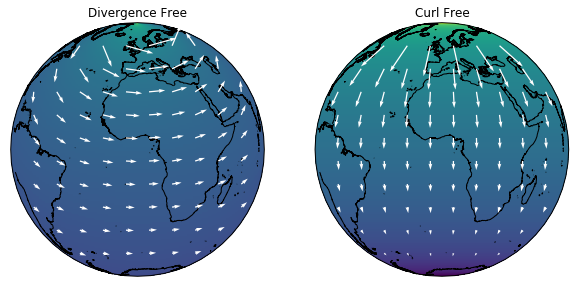

In [7]:
projection = ccrs.Orthographic(central_latitude=0, central_longitude=0)
proj_data = ccrs.PlateCarree()

fig, (ax_df, ax_cf) = plt.subplots(figsize=(10,10), ncols=2, subplot_kw=dict(projection=projection))

ax_df.add_feature(coast)
ax_cf.add_feature(coast)

norm = mpl.colors.LogNorm(vmin=1e-3, vmax=1e0)
cax = ax_df.pcolormesh(xx2, yy2, J_df_phi, norm=norm, transform=proj_data)
ax_df.quiver(xx, yy, J_df_y, J_df_x, transform=proj_data, regrid_shape=12, color='w', zorder=9)
# Add colorbar if you'd like
#plt.colorbar(cax, label='J$_\Phi$ (A/m$^2$)', orientation='horizontal')

norm = mpl.colors.LogNorm(vmin=1e-5, vmax=1e-2)
cax = ax_cf.pcolormesh(xx2, yy2, J_cf_theta, norm=norm, transform=proj_data)
ax_cf.quiver(xx, yy, J_cf_y, J_cf_x, transform=proj_data, regrid_shape=12, color='w', zorder=9)

ax_df.set_title('Divergence Free')
ax_cf.set_title('Curl Free')

# Figure 2

In [8]:
N = 1000
pred_loc = np.zeros(shape=(N, 3))
angles = np.linspace(0, 45, N)

pred_loc[:,0] = 90-angles
pred_loc[:,2] = R_E

B_pred = system_df.predict(pred_loc=pred_loc)

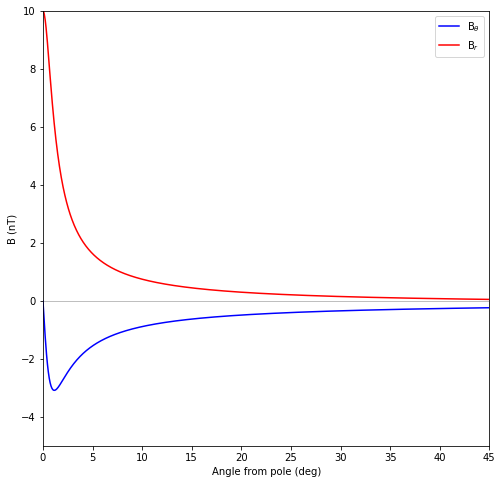

In [9]:
# B_theta == -Bx == -B_pred[:,0]
# Convert to nT (1e9)
B_theta = -B_pred[:,0]*1e9
# B_r == -Bz = -B_pred[:,2]
B_r = -B_pred[:,2]*1e9

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(angles, B_theta, c='b', label=r'B$_{\theta}$')
ax.plot(angles, B_r, c='r', label=r'B$_r$')
ax.legend(loc='upper right')
ax.set_xlim(angles[0], angles[-1])
ax.set_ylim(-5, 10)
ax.set_xlabel('Angle from pole (deg)')
ax.set_ylabel('B (nT)')
ax.axhline(0., c='k', alpha=0.5, linewidth=0.5)